## Recurrence Neural Networks Notebook

### Description:

This notebook aims to implement a **Recurrence Neural Network** for Forecasting Time Series.

As explained in the **SeriesAnalysis** notebook, this notebook may use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself. The results that will be used are the stationary series obtained from the original series, in order to verify if the **Recurrence Networks** are capable of forecasting both stationary and non stationary series

### Recurrence Networks brief introduction

# COMPLETE


In [1]:
#Packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# COMPLETE WITH PACKAGES FOR RECURRENCE

### Some useful functions -> COMPLETE WITH MORE IF NEEDED AND DELETE ONES NOT NEEDED

In [31]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

#Ploting a single time series
def plot_series(serie,title,xlabel,ylabel):
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(serie)
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.ylim([0, 2])
    plt.show()
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series

#train test split
def train_test(serie,numtest):
    train = serie.iloc[0:len(serie)-numtest]
    test = serie.iloc[len(serie)-numtest:]    
    return train, test
    
#Compute some error metrics
def errors(actual, predicted):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    
    errors = [['MAPE',mape],['ME',me],['MAE',mae],['MPE',mpe],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors

### Importing the series and differenciating in order to get stationary behavior

# NOTE:

Feel free to pick just one to implement the code. After the code if ready and good, we can simply repeat for the others.
I would suggest pick one that is "diff".

In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

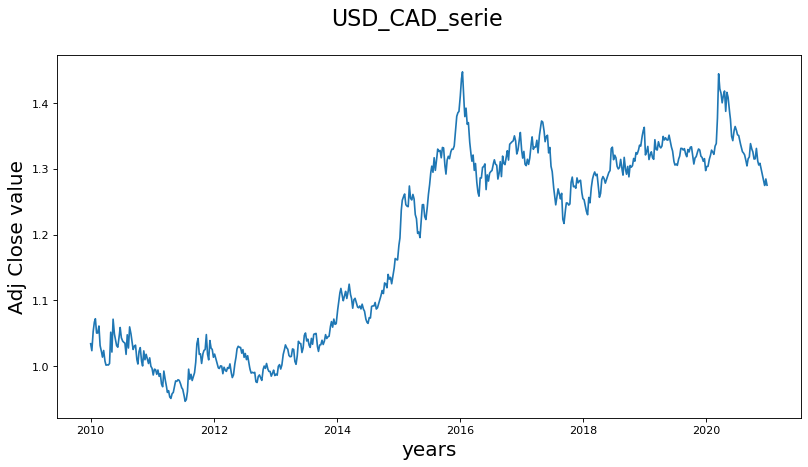

In [4]:
plot_series(USD_CAD_serie,'USD_CAD_serie','years','Adj Close value')

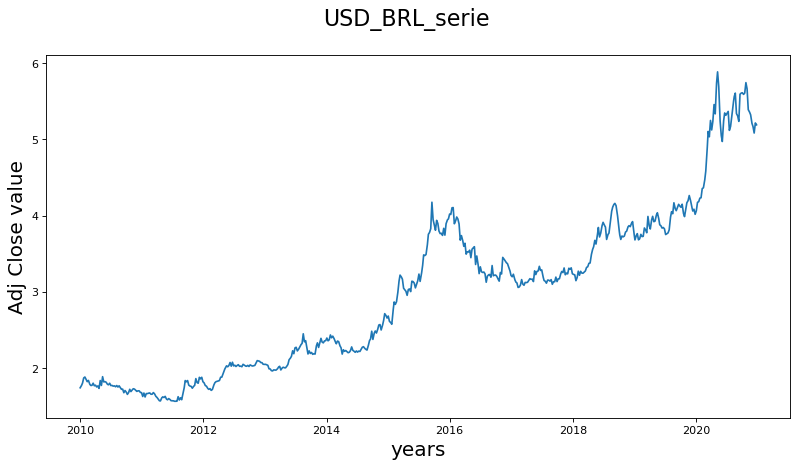

In [5]:
plot_series(USD_BRL_serie,'USD_BRL_serie','years','Adj Close value')

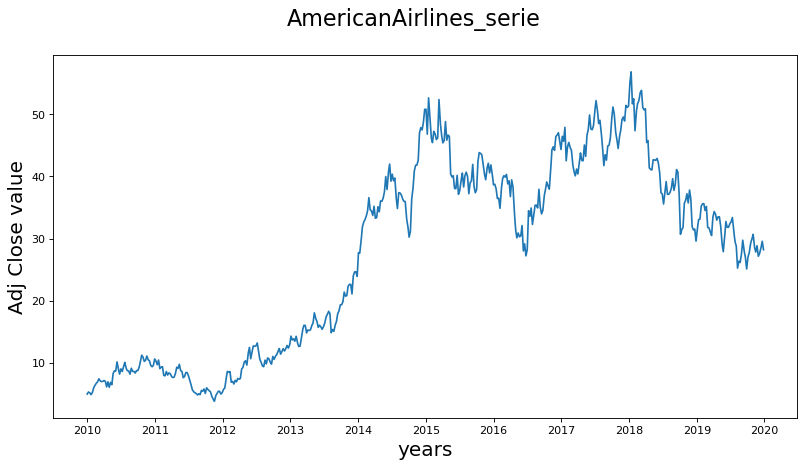

In [6]:
plot_series(AmericanAirlines_serie,'AmericanAirlines_serie','years','Adj Close value')

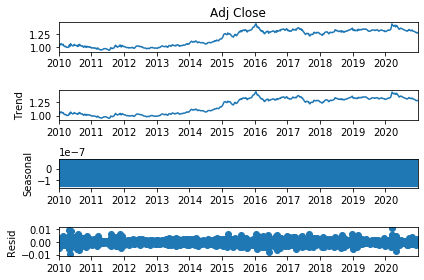

In [7]:
results = seasonal_decompose(USD_CAD_serie['Adj Close'])
results.plot();

In [8]:
len(USD_CAD_serie)

4012

In [9]:
USD_CAD_serie = USD_CAD_serie.iloc[:575]

In [10]:
len(USD_CAD_serie)

575

In [11]:
len(USD_BRL_serie)

4012

In [12]:
len(AmericanAirlines_serie)

3648

In [13]:
train_USD_CAD = USD_CAD_serie.iloc[:275]
test_USD_CAD = USD_CAD_serie.iloc[275:]
train_USD_BRL = USD_BRL_serie.iloc[:3500]
test_USD_BRL = USD_BRL_serie.iloc[3500:]
train_A_A = AmericanAirlines_serie.iloc[:3000]
test_A_A = AmericanAirlines_serie.iloc[3000:]

In [14]:

scaler = MinMaxScaler()

In [15]:
scaler.fit(train_USD_CAD)
scaled_train = scaler.transform(train_USD_CAD)
scaled_test = scaler.transform(test_USD_CAD)

In [16]:
scaled_train[:10]

array([[0.46175637],
       [0.44030757],
       [0.41885876],
       [0.39740996],
       [0.37596115],
       [0.35451234],
       [0.33306354],
       [0.31161473],
       [0.36665318],
       [0.42169162]])

In [17]:
len(test_USD_CAD)

300

In [18]:
test_USD_CAD.tail()

,Adj Close
Date,
2011-07-25,0.954117
2011-07-26,0.955863
2011-07-27,0.957609
2011-07-28,0.959354
2011-07-29,0.961100


In [19]:
# We do the same thing, but now instead for 12 months
n_input = 36
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')



In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(generator,epochs=1200)

Epoch 1/1200
263/263 [==============================] - 2s 4ms/step - loss: 0.0329
Epoch 2/1200
263/263 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 3/1200
263/263 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 4/1200
263/263 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 5/1200
263/263 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 6/1200
263/263 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 7/1200
263/263 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 8/1200
263/263 [==============================] - 1s 4ms/step - loss: 0.0025
Epoch 9/1200
263/263 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 10/1200
263/263 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 11/1200
263/263 [==============================] - 1s 4ms/step - loss: 0.0013
Epoch 12/1200
263/263 [==============================] - 1s 3ms/step - loss: 0.0014
E

263/263 [==============================] - 1s 4ms/step - loss: 6.3202e-04
Epoch 95/1200
263/263 [==============================] - 1s 3ms/step - loss: 4.9153e-04
Epoch 96/1200
263/263 [==============================] - 1s 3ms/step - loss: 4.4284e-04
Epoch 97/1200
263/263 [==============================] - ETA: 0s - loss: 4.7351e-0 - 1s 3ms/step - loss: 4.6424e-04
Epoch 98/1200
263/263 [==============================] - 1s 4ms/step - loss: 4.2619e-04
Epoch 99/1200
263/263 [==============================] - 1s 3ms/step - loss: 4.1005e-04
Epoch 100/1200
263/263 [==============================] - 1s 3ms/step - loss: 4.8359e-04
Epoch 101/1200
263/263 [==============================] - 1s 4ms/step - loss: 4.2577e-04
Epoch 102/1200
263/263 [==============================] - 1s 4ms/step - loss: 4.3044e-04
Epoch 103/1200
263/263 [==============================] - 1s 4ms/step - loss: 4.0426e-04
Epoch 104/1200
263/263 [==============================] - 1s 3ms/step - loss: 4.6340e-04
Epoch 105/120

Epoch 186/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.9224e-04
Epoch 187/1200
263/263 [==============================] - 1s 4ms/step - loss: 3.0547e-04
Epoch 188/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.9481e-04
Epoch 189/1200
263/263 [==============================] - 1s 4ms/step - loss: 3.7562e-04
Epoch 190/1200
263/263 [==============================] - 1s 3ms/step - loss: 3.1005e-04
Epoch 191/1200
263/263 [==============================] - 1s 3ms/step - loss: 2.9401e-04
Epoch 192/1200
263/263 [==============================] - 1s 3ms/step - loss: 2.9316e-04
Epoch 193/1200
263/263 [==============================] - 1s 4ms/step - loss: 3.2213e-04
Epoch 194/1200
263/263 [==============================] - 1s 4ms/step - loss: 3.1528e-04
Epoch 195/1200
263/263 [==============================] - 1s 4ms/step - loss: 3.3121e-04
Epoch 196/1200
263/263 [==============================] - 1s 3ms/step - loss: 2.8148e-04
Epoch 197/1200
263/26

Epoch 278/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.3427e-04
Epoch 279/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.0734e-04
Epoch 280/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.9731e-04
Epoch 281/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.9996e-04
Epoch 282/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.4218e-04
Epoch 283/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.0715e-04
Epoch 284/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.9279e-04
Epoch 285/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.4312e-04
Epoch 286/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.2559e-04
Epoch 287/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.2402e-04
Epoch 288/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.8643e-04
Epoch 289/1200
263/26

263/263 [==============================] - 1s 3ms/step - loss: 1.8117e-04
Epoch 371/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.9291e-04
Epoch 372/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.6380e-04
Epoch 373/1200
263/263 [==============================] - 1s 3ms/step - loss: 2.1798e-04A: 0s - l
Epoch 374/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.9462e-04
Epoch 375/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.9738e-04
Epoch 376/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.6925e-04
Epoch 377/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.9495e-04
Epoch 378/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.7725e-04
Epoch 379/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.0764e-04
Epoch 380/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.0291e-04
Epoch 381/1200
263/263 [===

263/263 [==============================] - 1s 4ms/step - loss: 2.1031e-04
Epoch 463/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.7533e-04
Epoch 464/1200
263/263 [==============================] - 1s 4ms/step - loss: 2.0892e-04
Epoch 465/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.7085e-04
Epoch 466/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.7390e-04
Epoch 467/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.6387e-04A: 0s 
Epoch 468/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.6857e-04
Epoch 469/1200
263/263 [==============================] - 1s 3ms/step - loss: 2.0255e-04
Epoch 470/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.4819e-04
Epoch 471/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.7697e-04
Epoch 472/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.7281e-04
Epoch 473/1200
263/263 [======

263/263 [==============================] - 1s 4ms/step - loss: 1.3368e-04
Epoch 555/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.5977e-04
Epoch 556/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.5675e-04
Epoch 557/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.4292e-04
Epoch 558/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.7887e-04
Epoch 559/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.8738e-04
Epoch 560/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.3652e-04
Epoch 561/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2881e-04
Epoch 562/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.3145e-04
Epoch 563/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.4107e-04
Epoch 564/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.5674e-04
Epoch 565/1200
263/263 [============

263/263 [==============================] - 1s 4ms/step - loss: 1.1581e-04
Epoch 647/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.5990e-04
Epoch 648/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.3382e-04
Epoch 649/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2995e-04
Epoch 650/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.6660e-04
Epoch 651/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.4893e-04
Epoch 652/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.3674e-04
Epoch 653/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.5601e-04
Epoch 654/1200
263/263 [==============================] - ETA: 0s - loss: 1.2678e-0 - 1s 4ms/step - loss: 1.2494e-04
Epoch 655/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2512e-04
Epoch 656/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.4557e-04
Epoch 65

263/263 [==============================] - 1s 4ms/step - loss: 1.3296e-04
Epoch 738/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1400e-04
Epoch 739/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2038e-04
Epoch 740/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1098e-04
Epoch 741/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2567e-04
Epoch 742/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.3756e-04
Epoch 743/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1679e-04
Epoch 744/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2087e-04
Epoch 745/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2657e-04
Epoch 746/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2202e-04
Epoch 747/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.0757e-04
Epoch 748/1200
263/263 [============

263/263 [==============================] - 1s 3ms/step - loss: 9.9904e-05
Epoch 830/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.0155e-04
Epoch 831/1200
263/263 [==============================] - 1s 3ms/step - loss: 8.4374e-05
Epoch 832/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.0933e-04
Epoch 833/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2595e-04
Epoch 834/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1765e-04
Epoch 835/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2334e-04
Epoch 836/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.4131e-04
Epoch 837/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.0737e-04
Epoch 838/1200
263/263 [==============================] - 1s 3ms/step - loss: 8.6939e-05
Epoch 839/1200
263/263 [==============================] - 1s 3ms/step - loss: 8.5931e-05
Epoch 840/1200
263/263 [============

Epoch 921/1200
263/263 [==============================] - 1s 4ms/step - loss: 9.7361e-05
Epoch 922/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2637e-04
Epoch 923/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.0923e-04
Epoch 924/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.2048e-04
Epoch 925/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.0978e-04
Epoch 926/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.4032e-04
Epoch 927/1200
263/263 [==============================] - 1s 4ms/step - loss: 9.1726e-05
Epoch 928/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.0345e-04
Epoch 929/1200
263/263 [==============================] - 1s 4ms/step - loss: 7.0911e-05
Epoch 930/1200
263/263 [==============================] - 1s 4ms/step - loss: 7.9560e-05
Epoch 931/1200
263/263 [==============================] - 1s 4ms/step - loss: 7.5666e-05
Epoch 932/1200
263/26

263/263 [==============================] - 1s 4ms/step - loss: 1.0685e-04
Epoch 1013/1200
263/263 [==============================] - 1s 4ms/step - loss: 7.5539e-05
Epoch 1014/1200
263/263 [==============================] - 1s 3ms/step - loss: 7.6802e-05
Epoch 1015/1200
263/263 [==============================] - 1s 3ms/step - loss: 9.1464e-05
Epoch 1016/1200
263/263 [==============================] - 1s 3ms/step - loss: 9.6654e-05
Epoch 1017/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.1627e-04
Epoch 1018/1200
263/263 [==============================] - 1s 3ms/step - loss: 8.5316e-05
Epoch 1019/1200
263/263 [==============================] - 1s 3ms/step - loss: 9.5301e-05
Epoch 1020/1200
263/263 [==============================] - 1s 3ms/step - loss: 7.1387e-05
Epoch 1021/1200
263/263 [==============================] - 1s 3ms/step - loss: 7.3636e-05
Epoch 1022/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.2095e-04
Epoch 1023/1200
263/263 [=

Epoch 1103/1200
263/263 [==============================] - 1s 4ms/step - loss: 6.9986e-05
Epoch 1104/1200
263/263 [==============================] - 1s 4ms/step - loss: 7.6498e-05
Epoch 1105/1200
263/263 [==============================] - 1s 3ms/step - loss: 9.0270e-05
Epoch 1106/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.1039e-04
Epoch 1107/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.0752e-04
Epoch 1108/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.0100e-04
Epoch 1109/1200
263/263 [==============================] - 1s 3ms/step - loss: 7.5849e-05
Epoch 1110/1200
263/263 [==============================] - 1s 4ms/step - loss: 8.7039e-05
Epoch 1111/1200
263/263 [==============================] - 1s 3ms/step - loss: 1.1304e-04
Epoch 1112/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1437e-04
Epoch 1113/1200
263/263 [==============================] - 1s 3ms/step - loss: 7.8510e-05
Epoch 1114

263/263 [==============================] - 1s 4ms/step - loss: 5.2319e-05
Epoch 1194/1200
263/263 [==============================] - 1s 4ms/step - loss: 5.7929e-05
Epoch 1195/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1878e-04
Epoch 1196/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1824e-04
Epoch 1197/1200
263/263 [==============================] - 1s 4ms/step - loss: 6.6889e-05
Epoch 1198/1200
263/263 [==============================] - 1s 4ms/step - loss: 1.1212e-04
Epoch 1199/1200
263/263 [==============================] - 1s 4ms/step - loss: 7.8824e-05
Epoch 1200/1200
263/263 [==============================] - 1s 4ms/step - loss: 4.9336e-05


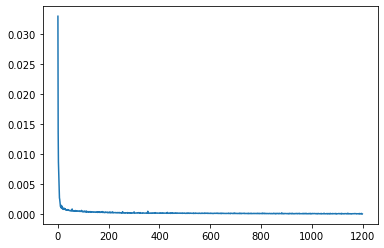

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

F:\anacondaPython\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


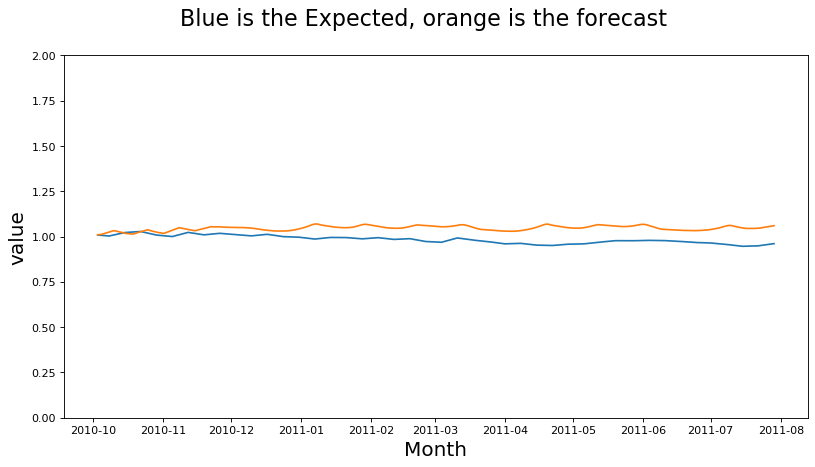

In [32]:
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_USD_CAD)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions = scaler.inverse_transform(test_predictions)
test_USD_CAD['prodict Adj close'] = true_predictions
#test_USD_CAD.plot(figsize=(14,5),)
plot_series(test_USD_CAD,'Blue is the Expected, orange is the forecast','Month','value')

## Training and Test Sets

We must divide our time series into a training and test sample. Since our series has anual seasonality, let's leave the last yeas as test sample and the rest of the series as training.

The size of the test series is the size of the largest forecast horizon.

In [25]:
largest_horizon = 12 #c12 weeks, 3 months

train_American_diff1, test_American_diff1 = train_test(AmericanAirlines_serie_diff1,largest_horizon)
train_USD_CAD_diff1, test_USD_CAD_diff1 = train_test(USD_CAD_serie_diff1,largest_horizon)
train_USD_BRL_diff2, test_USD_BRL_diff1 = train_test(USD_BRL_serie_diff1,largest_horizon)